# Analysis of Large MERFISH Data

**Date:** 2020-08-15<br>
**Data:** MERFISH large dataset : [LINK][1]<br>
**Description:** Application of the descriptive statistics to a larger dataset, to assess general trends across multiple samples. Three main features will be analyzed:<br>
* Univariate Ripley's K
* Bivariate Ripley's K
* PCF (Pair Correlation Function)


[1]: https://drive.google.com/file/d/1XbIodngrl3WhTyaQHDFeg5CJcgShj7ZG/view?usp=drive_web

## Load Libraries

We will be using some custom modules to reduce the amount of code in the notebook, namely: `spatstat`, `datasets` and `utils`.

In [1]:
%load_ext Cython
%load_ext autoreload
%autoreload 2

In [2]:
import spatstat as sp
import datasets
import utils as ut

import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path as osp
import os

## Load and Prepare Data

First set some global variables to make things easier for us

In [3]:
DATA_PTH = '/home/alma/w-projects/stx/data/MERFISH_MOp_MERFISH_MOp_0502.h5ad'
OUT_DIR_UNI = "/tmp/ripk_uni"
OUT_DIR_MUL = "/tmp/ripk_mul"
OUT_DIR_PCF = "/tmp/pcf"

Inspect the data to make sure everything looks allright

In [4]:
all_data = ad.read_h5ad(DATA_PTH)
all_data.obs

,volume,x,y,AP_distance,soma_depth,label,subclass,class_label,specimen_id,batch_id,slice
index,,,,,,,,,,,
10000143038275111136124942858811168393,992.830060,4738.397298,3075.327399,400.0,959.227100,Astro_1,Astrocytes,Other,2,4,31
100001798412490480358118871918100400402,610.091871,-3964.711404,1451.889047,1690.0,1246.938980,Endo,Endothelial,Other,2,5,160
100006878605830627922364612565348097824,148.277718,805.843523,1215.035473,1180.0,7.369782,SMC,SMC,Other,2,6,109
100007228202835962319771548915451072492,249.515471,1348.686198,-3589.955255,700.0,1123.956211,Endo,Endothelial,Other,1,2,71
100009332472089331948140672873134747603,1779.831996,-3584.650904,-1883.105955,2280.0,324.069916,L23_IT_3,L23_IT,Glutamatergic,2,5,219
...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,1208.963097,890.666985,1069.905972,2500.0,198.887653,Pvalb_1,Pvalb,GABAergic,1,5,251
99989592830367590092304100078674096866,611.167089,1913.334949,1280.947292,2700.0,772.996776,L5_PT_5,L5_PT,Glutamatergic,2,3,261
99991756591196613545069880666241120777,130.928366,3847.387896,3589.662245,1110.0,623.739723,L45_IT_4,L45_IT,Glutamatergic,1,3,112


Extract cells from the same datasets, for each subset extraction will be done based on:

* specimen id - only cells from the same specimen should be used 
* batch id - ensure cells come from the same batch
* slice - ensure cells comre from the same slice

all data will be stored as `MerfishData` objects in the `data` dictionary, keys are `[batch_id]_[slice]`.

we will use the `subclass` types in our analysis, to change this simply modify the definition of the `type_colname` variable.

_comment_ : it seems as if batch id is redundant for unique selection, slice id's would be enough to get the same results. Have not confirmed yet.

In [5]:
type_colname = "subclass"
data = dict()
ids = list()
mask_1 = all_data.obs["specimen_id"].values == 1

for batch_id in all_data.obs["batch_id"].unique():
    mask_2 = all_data.obs["batch_id"] == batch_id
    slice_ids = all_data.obs[mask_1 & mask_2].slice.unique()
    for slice_id in slice_ids:
        ids.append([batch_id, slice_id])

for batch,slice_id in ids:
    
    mask_2 = all_data.obs["batch_id"].values == batch
    mask_3 = all_data.obs["slice"].values == slice_id
    
    _subset = all_data[mask_1 & mask_2 & mask_3]
    data.update({"{}_{}".format(batch,slice_id):datasets.MerfishData(data = _subset,
                                                                    type_colname= type_colname)})


Inspect one sample and check whether the computed edge distances (used in edge correction) makes sense. First sample in the data set will be used for visualization.

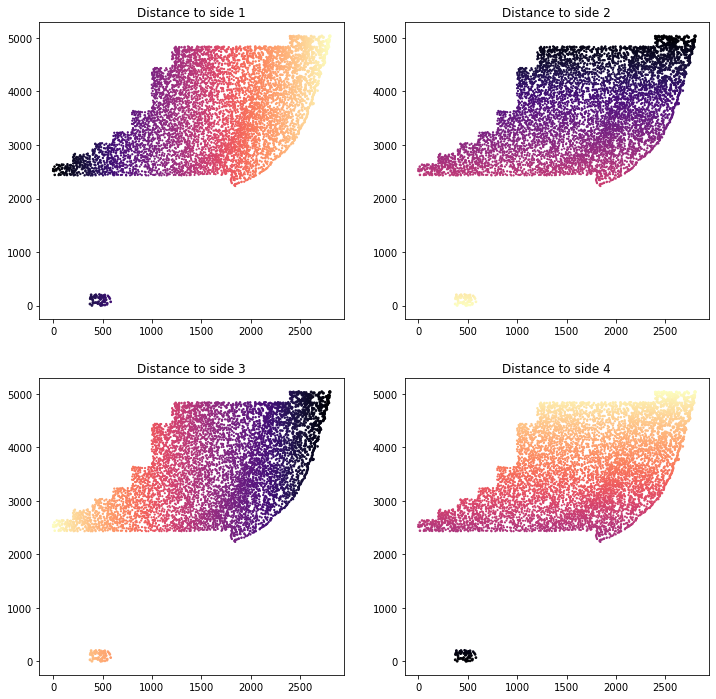

In [6]:
firstkey = list(data.keys())[0]
edgedistances = data[firstkey]._get_edgedistances()

fig,ax = plt.subplots(2,2,figsize = (12,12))
ws = data[firstkey].weights(1200)
ax = ax.flatten()
for k in range(4):
    
    ax[k].scatter(data[firstkey].crd[:,0],
                  data[firstkey].crd[:,1],
                  c = edgedistances[:,k],
                  cmap = plt.cm.magma,
                  s = ws / ws.max() * 5,
                 )
    ax[k].set_title("Distance to side {}".format(k+1))
    
plt.show()

## Analysis

### Univariate Ripley's K : Compuations

We'll compute $K_{uni}(t)$ for all sections and store the results in `OUT_DIR_UNI`. We will generate results where edge correction (tagged with `EC`) is respectively is not present (tagged with `OR`). 

The edge correction only supports distances that are at most half the length of the shortest side of the bounding box, hence we set the upper bound to half the shortest length among all samples.

`n_steps` different distances between $[0,\textrm{upper_bound}]$ will be analyzed. 

We will save each results to a `.tsv` file, to ensure these are kept (in case of a crashed notebook etc., since these take quite some time to compute).

Set the variable `save` to `True` to save the results, a safety measure to avoid accidentally overwriting old results. 

In [ ]:
save = False

upper_bound = np.min([d.minside for d in data.values()])
upper_bound /= 2

n_steps = 500

radii = np.linspace(0,upper_bound,n_steps)

for nd,(sample,d) in enumerate(data.items()):
    
    
    res_ec = dict()
    res_or = dict()
    
    for nt,ct in enumerate(d.uni_types):
        
        print("Sample {}/{} | Type {}/{}"\
              .format(nd,len(data),nt,len(d.uni_types)))
        
        sel = d.types == ct
        
        rKs_ec = list()
        rKs_or = list()
        
        for radius in radii:
            ws = d.weights(radius)[sel]
            
            _rK_ec = K_uni(t = radius,
                           crd = d.crd[sel],
                           A = d.area,
                           ws = ws)
            
            _rK_or = K_uni(t = radius,
                           crd = d.crd[sel],
                           A = d.area,
                           ws = np.ones(len(ws)))
            
            rKs_ec.append(_rK_ec)
            rKs_or.append(_rK_or)
    
        res_ec.update({ct:rKs_ec})
        res_or.update({ct:rKs_or})
    
    res_ec = pd.DataFrame(res_ec,
                          index = pd.Index(radii))
    res_or = pd.DataFrame(res_or,
                          index = pd.Index(radii))
    
    
    if save:
        basename = sample + "-#" + ".tsv"
        res_ec.to_csv(osp.join(OUT_DIR_UNI,basename.replace("#","EC")),
                      sep = '\t')
        res_or.to_csv(osp.join(OUT_DIR_UNI,basename.replace("#","OR")),
                      sep = '\t')
    else:
        print("NOTE: RESULTS ARE NOT SAVED")
    

Load the results for the Ripley's K analysis. For this we use the `load_results` function, while the `merge_results` function puts all the results in a single `[n_samples]x[n_distances]x[n_types]` tensor.

`load_function` will adjust results file such that columns and rows agree, if a cell type is not present in one sample zeros will be added for all distances.

In [7]:
# add a filter to only look at the results where edge correction
# was used. Change EC--> OR for the opposite.

use_edgecorrection = lambda x: "-EC" in x

results,columns,indices = ut.load_results(dirname = OUT_DIR_UNI,
                                       filters = use_edgecorrection,
                                      )


results_tensor = ut.merge_results(results,
                                  columns,
                                  indices)

Generate data frames from the tensor, one containing the means and one the standard deviations.

In [8]:
results_mu = pd.DataFrame(results_tensor.mean(axis = 0),
                          index = indices,
                          columns = columns,
                         )

results_sd = pd.DataFrame(results_tensor.std(axis = 0),
                          index = indices,
                          columns = columns,
                         )


### Univariate Ripley's K : Visualization 
Visualize the results, by plotting the $K_{uni}(r)$ values against the radius, values for a CSR is included as a reference.

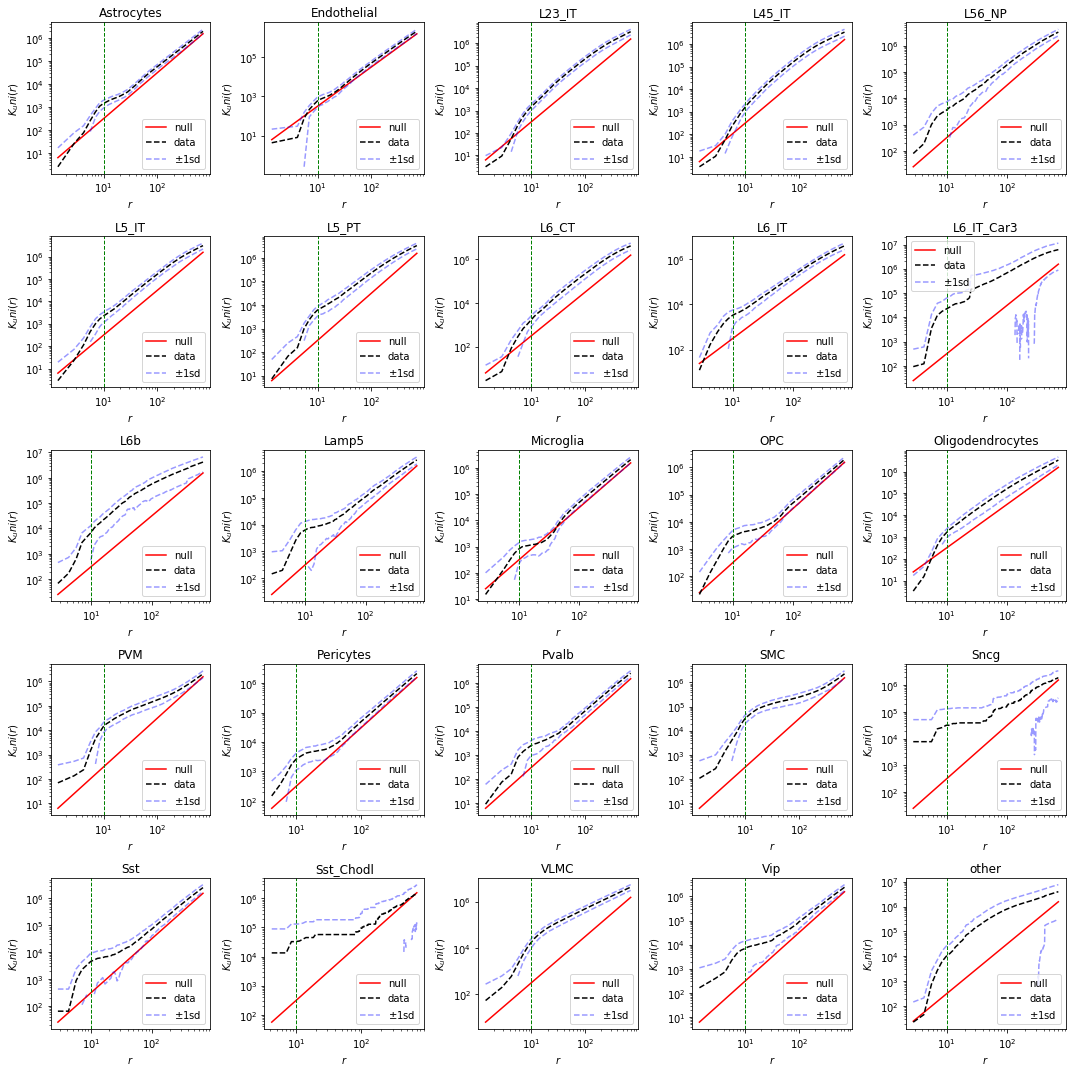

In [11]:
n_cols = 5
n_rows = int(np.ceil(len(columns) / n_cols))

ref_dist = 10

radii = results_mu.index.values

figsize = (n_cols * 3, n_rows * 3)

fig,ax = plt.subplots(n_cols,n_rows, figsize = figsize)
ax = ax.flatten()

theo = np.array([np.pi*(d**2) for d in radii])

for k,ct in enumerate(results_mu.columns.values):

    nz = results_mu[ct].values > 0

    ut.plot_results(ax[k],
                    x_vals = radii[nz],
                    obs = results_mu[ct].values[nz],
                    std = results_sd[ct].values[nz],
                    theo = theo[nz],
                    vertical_reference = 10,
                    )

    ax[k].set_title(ct)
    ax[k].set_xlabel(r"$r$")
    ax[k].set_ylabel(r"$K_uni(r)$")

    
fig.tight_layout()
plt.show()

Next, we can inspect certain cell types to see if the results above resonate with the distribution we observe. We use the `visualize_types` function from the `utils` module for this.

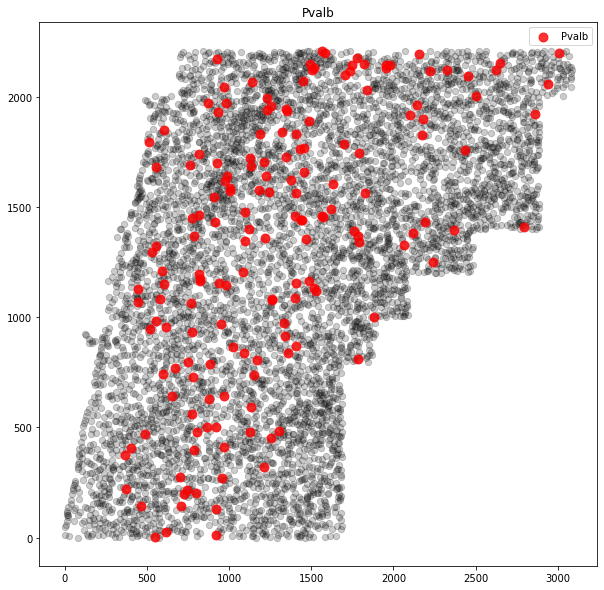

In [12]:
visualize_type = "Pvalb"
visualize_sample = 4

fk = list(data.keys())[visualize_sample]
crd = data[fk].crd

fig,ax = plt.subplots(1,1,figsize = (10,10))

ut.visualize_types(ax,
                  crd,
                  labels = data[fk].types,
                  selected = visualize_type,
                  cmap = "one_two",
                 )

ax.set_title(visualize_type)

plt.show()

### Bivariate Ripley's K : Computation

Similar to the univariate form, but here we use:

\begin{equation}
K_{bi}(r) = \frac{A}{n_1 n_2}\sum_{i=1}^{n_2}w_i\sum_{j=1}^{n_1} I_r(x_i,x_j)
\end{equation}

Where summation over $i$ and $j$ occurs over different cell types. Note that $K_{bi}(r)$ is _not_ symmetric, when weights for edge correction are used in the scheme.

Here we only compute results when edge correction is implemented.


In [ ]:
save = False

upper_bound = np.min([d.minside for d in data.values()])
upper_bound /= 2

radii = np.exp(np.linspace(0,np.log(upper_bound),100))

for nd,(sample,d) in enumerate(data.items()):
    
    
    res_ec = dict()
    
    for nt1,ct1 in enumerate(d.uni_types):
        for nt2,ct2 in enumerate(d.uni_types):
            if ct2 == ct1: 
                continue
                
            print("Sample {}/{} | Pair {}/{} "\
                  .format(nd+1,len(data),(nt1*len(d.uni_types)) +\
                          nt2 + 1,len(d.uni_types)**2))

            sel1 = d.types == ct1
            sel2 = d.types == ct2

            rKs_ec = list()

            for radius in radii:
                ws = d.weights(radius)[sel1]

                _rK_ec = sp.K_mul(t = radius,
                               crd1 = d.crd[sel1,:],
                               crd2 = d.crd[sel2,:],
                               A = d.area,
                               ws = ws)

                rKs_ec.append(_rK_ec)

            res_ec.update({ct1 + "_" + ct2:rKs_ec})

    res_ec = pd.DataFrame(res_ec,index = pd.Index(radii))

    if save:
        basename = sample + "-#" + ".tsv"
        res_ec.to_csv(osp.join(OUT_DIR_MUL,basename.replace("#","EC")),sep = '\t')

Load the generated results and compute mean as well as standard deviations.

In [13]:


results,columns,indices = ut.load_results(dirname = OUT_DIR_MUL,
                                      )

results_tensor = ut.merge_results(results,
                                  columns,
                                  indices)

results_mu = pd.DataFrame(results_tensor.mean(axis = 0),
                          index = indices,
                          columns = columns,
                         )

results_sd = pd.DataFrame(results_tensor.std(axis = 0),
                          index = indices,
                          columns = columns,
                         )


### Bivariate Ripley's K : Visualization

Similarly to the univariate case, we first look at $K_{bi}(t)$ as a function of the radius ($r$). Since there number of cell type combinations is high and we don't want to plot every single one one of them, we randomly select 25 pairs to visualize our results.

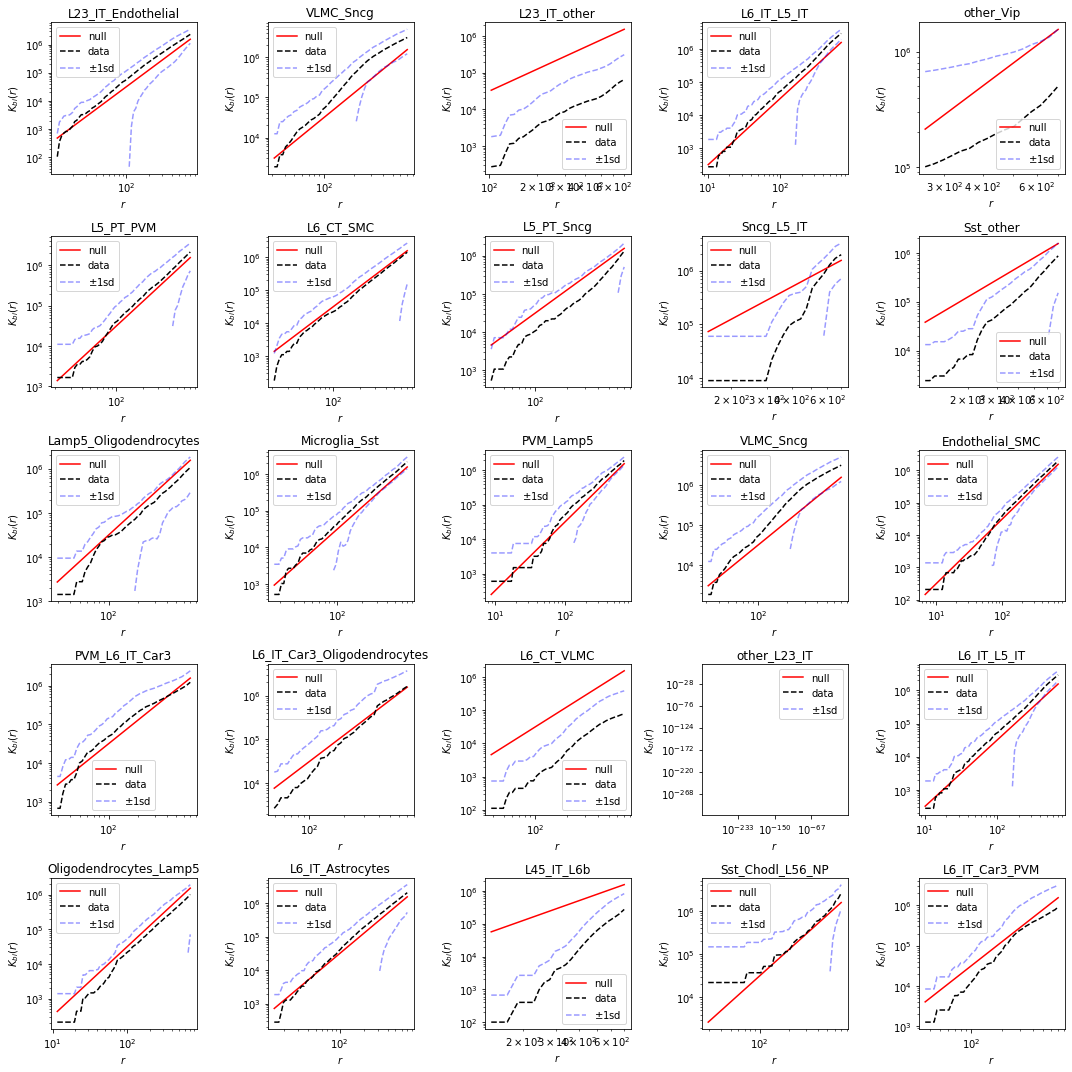

In [14]:
n_show = 25
n_cols = 5
n_rows = int(np.ceil(n_show / n_cols))

ref_dist = 100

radii = results_mu.index.values

figsize = (n_cols * 3,
           n_rows * 3)

fig,ax = plt.subplots(n_cols,n_rows, figsize = figsize)
ax = ax.flatten()

theo = np.array([np.pi*(d**2) for d in radii])

cell_types = np.random.choice(results_mu.columns,n_show)

for k,ct in enumerate(cell_types):

    nz = results_mu[ct].values > 0

    ut.plot_results(ax[k],
                    x_vals = radii[nz],
                    obs = results_mu[ct].values[nz],
                    std = results_sd[ct].values[nz],
                    theo = theo[nz],
                    )

    ax[k].set_title(ct)

    ax[k].legend()
    ax[k].set_xlabel(r"$r$")
    ax[k].set_ylabel(r"$K_{bi}(r)$")

    
fig.tight_layout()
plt.show()

Again, as for the univariate case we can visualize the actual distribution of our types in a sample - the same function as before can be used for this.

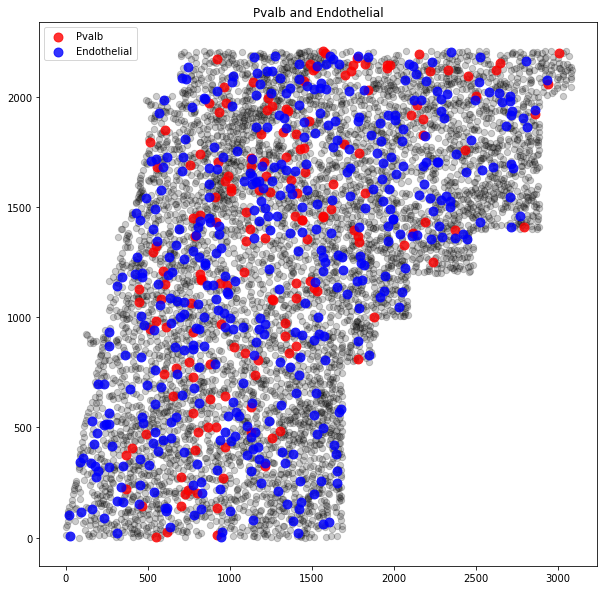

In [58]:
visualize_type_1 = "Pvalb"
visualize_type_2 = "Endothelial"
visualize_sample = 4


selected = [visualize_type_1,visualize_type_2]
fk = list(data.keys())[visualize_sample]

crd = data[fk].crd

fig,ax = plt.subplots(1,1,figsize = (10,10))

ut.visualize_types(ax,
                  crd,
                  labels = data[fk].types,
                  selected = selected,
                  cmap = "one_two",
                 )
ax.set_title("{} and {}".format(visualize_type_1,
                                visualize_type_2))

plt.show()

### PCF : Computation 

Next, we look at the Pair Correlation Function (PCF), just as for the bivariate case we will look at all pairs of cell types. The PCF, in contrast to Ripley's K, uses an _annulus_ as a search region - this reduces the risk for signals at short distances to interfere with those observed at larger distances. However, it also requires that a `bandwidth` is set, which determines the shape of the annulus. In other words, the bandwidth dictates how broad the region around a specified search radius should be - see image below:

<img src="img/annulus.png">

In [71]:
save = True
bandwidth = 20
upper_bound = np.min([d.minside for d in data.values()])
upper_bound /= 2

radii = np.linspace(2*bandwidth,upper_bound-bandwidth,500)

for nd,(sample,d) in enumerate(data.items()):
    
    res_pcf = dict()
    
    for nt1,ct1 in enumerate(d.uni_types):
        for nt2,ct2 in enumerate(d.uni_types):
            if ct2 == ct1: 
                continue
                
            print("Sample {}/{} | Pair {}/{} "\
                  .format(nd+1,len(data),(nt1*len(d.uni_types)) +\
                          nt2 + 1,len(d.uni_types)**2))

            sel1 = d.types == ct1
            sel2 = d.types == ct2

            pcfs = list()

            for radius in radii:
                _pcf = sp.PCF_r(r = radius,
                                crd1 = d.crd[sel1,:],
                                crd2 = d.crd[sel2,:],
                                A = d.area,
                                h = bandwidth,
                                )

                pcfs.append(_pcf)

            res_pcf.update({ct1 + "_" + ct2:pcfs})

    res_pcf = pd.DataFrame(res_pcf,
                           index = pd.Index(radii))

    if save:
        basename = sample + "-bw-{}-".format(bandwidth) + ".tsv"
        res_pcf.to_csv(osp.join(OUT_DIR_PCF,
                                basename),
                       sep = '\t')

Sample 1/33 | Pair 2/625 
Sample 1/33 | Pair 3/625 
Sample 1/33 | Pair 4/625 
Sample 1/33 | Pair 5/625 
Sample 1/33 | Pair 6/625 
Sample 1/33 | Pair 7/625 
Sample 1/33 | Pair 8/625 
Sample 1/33 | Pair 9/625 
Sample 1/33 | Pair 10/625 
Sample 1/33 | Pair 11/625 
Sample 1/33 | Pair 12/625 
Sample 1/33 | Pair 13/625 
Sample 1/33 | Pair 14/625 
Sample 1/33 | Pair 15/625 
Sample 1/33 | Pair 16/625 
Sample 1/33 | Pair 17/625 
Sample 1/33 | Pair 18/625 
Sample 1/33 | Pair 19/625 
Sample 1/33 | Pair 20/625 
Sample 1/33 | Pair 21/625 
Sample 1/33 | Pair 22/625 
Sample 1/33 | Pair 23/625 
Sample 1/33 | Pair 24/625 
Sample 1/33 | Pair 25/625 
Sample 1/33 | Pair 26/625 
Sample 1/33 | Pair 28/625 
Sample 1/33 | Pair 29/625 
Sample 1/33 | Pair 30/625 
Sample 1/33 | Pair 31/625 
Sample 1/33 | Pair 32/625 
Sample 1/33 | Pair 33/625 
Sample 1/33 | Pair 34/625 
Sample 1/33 | Pair 35/625 
Sample 1/33 | Pair 36/625 
Sample 1/33 | Pair 37/625 
Sample 1/33 | Pair 38/625 
Sample 1/33 | Pair 39/625 
Sample 1/

Sample 1/33 | Pair 311/625 
Sample 1/33 | Pair 312/625 
Sample 1/33 | Pair 314/625 
Sample 1/33 | Pair 315/625 
Sample 1/33 | Pair 316/625 
Sample 1/33 | Pair 317/625 
Sample 1/33 | Pair 318/625 
Sample 1/33 | Pair 319/625 
Sample 1/33 | Pair 320/625 
Sample 1/33 | Pair 321/625 
Sample 1/33 | Pair 322/625 
Sample 1/33 | Pair 323/625 
Sample 1/33 | Pair 324/625 
Sample 1/33 | Pair 325/625 
Sample 1/33 | Pair 326/625 
Sample 1/33 | Pair 327/625 
Sample 1/33 | Pair 328/625 
Sample 1/33 | Pair 329/625 
Sample 1/33 | Pair 330/625 
Sample 1/33 | Pair 331/625 
Sample 1/33 | Pair 332/625 
Sample 1/33 | Pair 333/625 
Sample 1/33 | Pair 334/625 
Sample 1/33 | Pair 335/625 
Sample 1/33 | Pair 336/625 
Sample 1/33 | Pair 337/625 
Sample 1/33 | Pair 338/625 
Sample 1/33 | Pair 340/625 
Sample 1/33 | Pair 341/625 
Sample 1/33 | Pair 342/625 
Sample 1/33 | Pair 343/625 
Sample 1/33 | Pair 344/625 
Sample 1/33 | Pair 345/625 
Sample 1/33 | Pair 346/625 
Sample 1/33 | Pair 347/625 
Sample 1/33 | Pair 3

Sample 1/33 | Pair 617/625 
Sample 1/33 | Pair 618/625 
Sample 1/33 | Pair 619/625 
Sample 1/33 | Pair 620/625 
Sample 1/33 | Pair 621/625 
Sample 1/33 | Pair 622/625 
Sample 1/33 | Pair 623/625 
Sample 1/33 | Pair 624/625 
Sample 2/33 | Pair 2/625 
Sample 2/33 | Pair 3/625 
Sample 2/33 | Pair 4/625 
Sample 2/33 | Pair 5/625 
Sample 2/33 | Pair 6/625 
Sample 2/33 | Pair 7/625 
Sample 2/33 | Pair 8/625 
Sample 2/33 | Pair 9/625 
Sample 2/33 | Pair 10/625 
Sample 2/33 | Pair 11/625 
Sample 2/33 | Pair 12/625 
Sample 2/33 | Pair 13/625 
Sample 2/33 | Pair 14/625 
Sample 2/33 | Pair 15/625 
Sample 2/33 | Pair 16/625 
Sample 2/33 | Pair 17/625 
Sample 2/33 | Pair 18/625 
Sample 2/33 | Pair 19/625 
Sample 2/33 | Pair 20/625 
Sample 2/33 | Pair 21/625 
Sample 2/33 | Pair 22/625 
Sample 2/33 | Pair 23/625 
Sample 2/33 | Pair 24/625 
Sample 2/33 | Pair 25/625 
Sample 2/33 | Pair 26/625 
Sample 2/33 | Pair 28/625 
Sample 2/33 | Pair 29/625 
Sample 2/33 | Pair 30/625 
Sample 2/33 | Pair 31/625 
S

Sample 2/33 | Pair 303/625 
Sample 2/33 | Pair 304/625 
Sample 2/33 | Pair 305/625 
Sample 2/33 | Pair 306/625 
Sample 2/33 | Pair 307/625 
Sample 2/33 | Pair 308/625 
Sample 2/33 | Pair 309/625 
Sample 2/33 | Pair 310/625 
Sample 2/33 | Pair 311/625 
Sample 2/33 | Pair 312/625 
Sample 2/33 | Pair 314/625 
Sample 2/33 | Pair 315/625 
Sample 2/33 | Pair 316/625 
Sample 2/33 | Pair 317/625 
Sample 2/33 | Pair 318/625 
Sample 2/33 | Pair 319/625 
Sample 2/33 | Pair 320/625 
Sample 2/33 | Pair 321/625 
Sample 2/33 | Pair 322/625 
Sample 2/33 | Pair 323/625 
Sample 2/33 | Pair 324/625 
Sample 2/33 | Pair 325/625 
Sample 2/33 | Pair 326/625 
Sample 2/33 | Pair 327/625 
Sample 2/33 | Pair 328/625 
Sample 2/33 | Pair 329/625 
Sample 2/33 | Pair 330/625 
Sample 2/33 | Pair 331/625 
Sample 2/33 | Pair 332/625 
Sample 2/33 | Pair 333/625 
Sample 2/33 | Pair 334/625 
Sample 2/33 | Pair 335/625 
Sample 2/33 | Pair 336/625 
Sample 2/33 | Pair 337/625 
Sample 2/33 | Pair 338/625 
Sample 2/33 | Pair 3

Sample 2/33 | Pair 609/625 
Sample 2/33 | Pair 610/625 
Sample 2/33 | Pair 611/625 
Sample 2/33 | Pair 612/625 
Sample 2/33 | Pair 613/625 
Sample 2/33 | Pair 614/625 
Sample 2/33 | Pair 615/625 
Sample 2/33 | Pair 616/625 
Sample 2/33 | Pair 617/625 
Sample 2/33 | Pair 618/625 
Sample 2/33 | Pair 619/625 
Sample 2/33 | Pair 620/625 
Sample 2/33 | Pair 621/625 
Sample 2/33 | Pair 622/625 
Sample 2/33 | Pair 623/625 
Sample 2/33 | Pair 624/625 
Sample 3/33 | Pair 2/529 
Sample 3/33 | Pair 3/529 
Sample 3/33 | Pair 4/529 
Sample 3/33 | Pair 5/529 
Sample 3/33 | Pair 6/529 
Sample 3/33 | Pair 7/529 
Sample 3/33 | Pair 8/529 
Sample 3/33 | Pair 9/529 
Sample 3/33 | Pair 10/529 
Sample 3/33 | Pair 11/529 
Sample 3/33 | Pair 12/529 
Sample 3/33 | Pair 13/529 
Sample 3/33 | Pair 14/529 
Sample 3/33 | Pair 15/529 
Sample 3/33 | Pair 16/529 
Sample 3/33 | Pair 17/529 
Sample 3/33 | Pair 18/529 
Sample 3/33 | Pair 19/529 
Sample 3/33 | Pair 20/529 
Sample 3/33 | Pair 21/529 
Sample 3/33 | Pair 2

Sample 3/33 | Pair 296/529 
Sample 3/33 | Pair 297/529 
Sample 3/33 | Pair 298/529 
Sample 3/33 | Pair 299/529 
Sample 3/33 | Pair 300/529 
Sample 3/33 | Pair 301/529 
Sample 3/33 | Pair 302/529 
Sample 3/33 | Pair 303/529 
Sample 3/33 | Pair 304/529 
Sample 3/33 | Pair 305/529 
Sample 3/33 | Pair 306/529 
Sample 3/33 | Pair 307/529 
Sample 3/33 | Pair 308/529 
Sample 3/33 | Pair 309/529 
Sample 3/33 | Pair 310/529 
Sample 3/33 | Pair 311/529 
Sample 3/33 | Pair 312/529 
Sample 3/33 | Pair 314/529 
Sample 3/33 | Pair 315/529 
Sample 3/33 | Pair 316/529 
Sample 3/33 | Pair 317/529 
Sample 3/33 | Pair 318/529 
Sample 3/33 | Pair 319/529 
Sample 3/33 | Pair 320/529 
Sample 3/33 | Pair 321/529 
Sample 3/33 | Pair 322/529 
Sample 3/33 | Pair 323/529 
Sample 3/33 | Pair 324/529 
Sample 3/33 | Pair 325/529 
Sample 3/33 | Pair 326/529 
Sample 3/33 | Pair 327/529 
Sample 3/33 | Pair 328/529 
Sample 3/33 | Pair 329/529 
Sample 3/33 | Pair 330/529 
Sample 3/33 | Pair 331/529 
Sample 3/33 | Pair 3

Sample 4/33 | Pair 76/625 
Sample 4/33 | Pair 77/625 
Sample 4/33 | Pair 78/625 
Sample 4/33 | Pair 80/625 
Sample 4/33 | Pair 81/625 
Sample 4/33 | Pair 82/625 
Sample 4/33 | Pair 83/625 
Sample 4/33 | Pair 84/625 
Sample 4/33 | Pair 85/625 
Sample 4/33 | Pair 86/625 
Sample 4/33 | Pair 87/625 
Sample 4/33 | Pair 88/625 
Sample 4/33 | Pair 89/625 
Sample 4/33 | Pair 90/625 
Sample 4/33 | Pair 91/625 
Sample 4/33 | Pair 92/625 
Sample 4/33 | Pair 93/625 
Sample 4/33 | Pair 94/625 
Sample 4/33 | Pair 95/625 
Sample 4/33 | Pair 96/625 
Sample 4/33 | Pair 97/625 
Sample 4/33 | Pair 98/625 
Sample 4/33 | Pair 99/625 
Sample 4/33 | Pair 100/625 
Sample 4/33 | Pair 101/625 
Sample 4/33 | Pair 102/625 
Sample 4/33 | Pair 103/625 
Sample 4/33 | Pair 104/625 
Sample 4/33 | Pair 106/625 
Sample 4/33 | Pair 107/625 
Sample 4/33 | Pair 108/625 
Sample 4/33 | Pair 109/625 
Sample 4/33 | Pair 110/625 
Sample 4/33 | Pair 111/625 
Sample 4/33 | Pair 112/625 
Sample 4/33 | Pair 113/625 
Sample 4/33 | P

KeyboardInterrupt: 

Load the results

In [72]:
results,columns,indices = ut.load_results(dirname = OUT_DIR_PCF,
                                      )

results_tensor = ut.merge_results(results,
                                  columns,
                                  indices)

results_mu = pd.DataFrame(results_tensor.mean(axis = 0),
                          index = indices,
                          columns = columns,
                         )

results_sd = pd.DataFrame(results_tensor.std(axis = 0),
                          index = indices,
                          columns = columns,
                         )


### PCF : Visualization

As before, we plot the PCF values (for a given bandwidth) as a function of the radius. A reference is included which represents the expected values ($1$) if no interactions between the cell types occured.

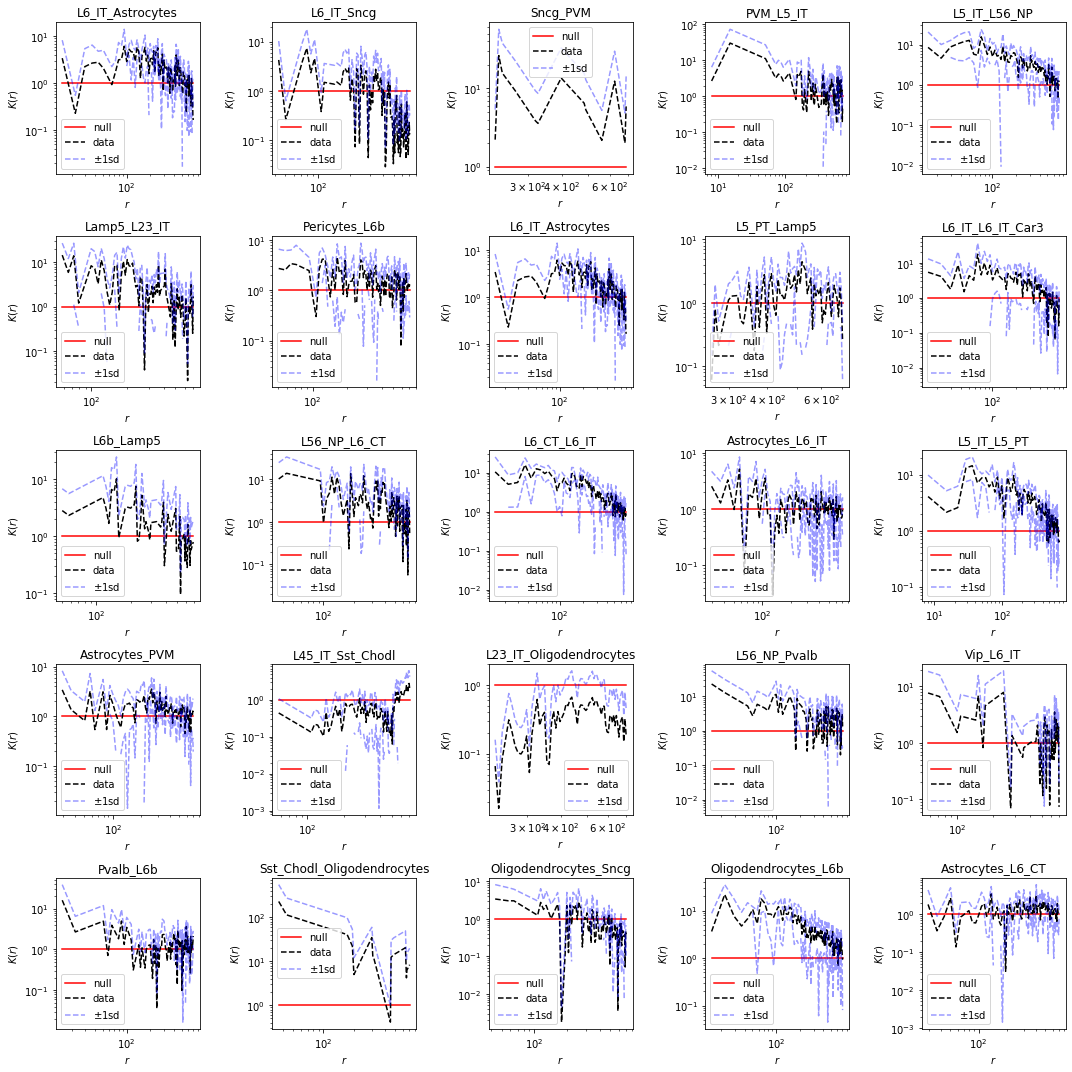

In [73]:
n_show = 25
n_cols = 5
n_rows = int(np.ceil(n_show / n_cols))

ref_dist = 100

radii = results_mu.index.values

figsize = (n_cols * 3,
           n_rows * 3)

fig,ax = plt.subplots(n_cols,
                      n_rows,
                      figsize = figsize)
ax = ax.flatten()

theo = np.ones(radii.shape[0])

cell_types = np.random.choice(results_mu.columns,n_show)

for k,ct in enumerate(cell_types):

    nz = results_mu[ct].values > 0

    ut.plot_results(ax[k],
                    x_vals = radii[nz],
                    obs = results_mu[ct].values[nz],
                    std = results_sd[ct].values[nz],
                    theo = theo[nz],
                    )

    ax[k].set_xscale("log")
    ax[k].set_yscale("log")
    ax[k].set_title(ct)
    
    ax[k].set_xlabel(r"$r$")
    ax[k].set_ylabel(r"$K(r)$")

    
fig.tight_layout()
plt.show()

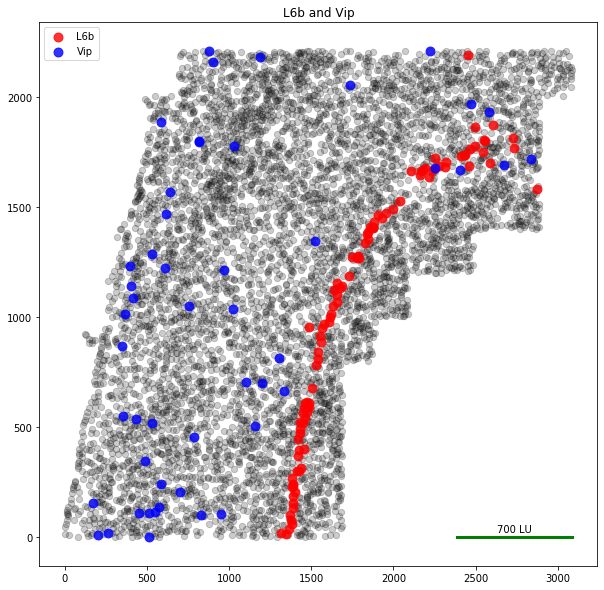

In [69]:
visualize_type_1 = "L6b"
visualize_type_2 = "Vip"

selected = [visualize_type_1,visualize_type_2]

visualize_sample = 4

fk = list(data.keys())[visualize_sample]
crd = data[fk].crd
sel_1 = data[fk].types == visualize_type_1
sel_2 = data[fk].types == visualize_type_2


fig,ax = plt.subplots(1,
                      1,
                      figsize = (10,10))

ut.visualize_types(ax,
                  crd,
                  labels = data[fk].types,
                  selected = selected,
                  cmap = "one_two",
                  reference_distance = 700,
                 )
ax.set_title("{} and {}".format(visualize_type_1,
                                visualize_type_2))

plt.show()